In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
#from evaluation_functions import ensemble_evaluation_functions as eef
#import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
#from calibration_functions import huxt_rank_functions as hrf

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number


# from sklearn.calibration import calibration_curve
# from sklearn.utils import resample
# from sklearn.metrics import mean_squared_error

c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_files_containing_words(directory, keywords):
    """
    creates list of all file name strings containing desired keywords

    Args:
        directory (string) : directory where files are stored
        keywords (list): list of desired keywords
    Returns:
        filtered_files (list) : list of filtered file names with desired keywords
    """

    # Get the list of all files in the directory
    all_files = os.listdir(directory)
    
    # Filter files that contain any of the specified words
    filtered_files = [file for file in all_files if any(word in file for word in keywords)]
    
    return filtered_files


def wsa_date_from_string(file_string):

    """
    extracts date from wsa filename

    Args:
        file_string (string) : wsa model solution file name string
    Returns:
        date_string (string) : date string generated from info within file string format
    """

    # Define regular expression pattern to extract the date
    pattern = r'%2F(\d{4})%2F(\d{1,2})%2F(\d{1,2})%2F'

    # Search for the pattern in the file string
    match = re.search(pattern, file_string)

    if match:
        year, month, day = match.groups()
        date_string = f'{year}-{month}-{day}'
    else:
        print("No date found in the string")

    return date_string

def earth_latitude_wsa(filename):

    """
    creates list of all file name strings containing desired keywords

    Args:
        filename (string) : wsa model solution file name
    Returns:
        E_lat (float) : average heliolatitude of Earth during timeframe of WSA solution in radians 
    """
        
    # HUXt model parameters
    dt_scale = 4
    r_min = 21.5 * u.solRad
    forecast_window = 27 * u.day

    # getting velocity profile and start time and cr longitude
    init_wsa_date = wsa_date_from_string(filename)
    cr, cr_lon_init = Hin.datetime2huxtinputs(pd.Timestamp(init_wsa_date))

    # Use the HUXt ephemeris data to get Earth lat over the CR
    dummymodel = H.HUXt(v_boundary=np.ones(128)*400*(u.km/u.s), simtime=forecast_window, dt_scale=dt_scale, cr_num=cr,
                        cr_lon_init=cr_lon_init, lon_out=0.0*u.deg, r_min = r_min)

    # Retrieve a bodies position at each model timestep:
    earth = dummymodel.get_observer('earth')

    # Get average Earth lat
    E_lat = np.nanmean(earth.lat_c)

    return E_lat


def interpolate_vmap(velocity_map, lats, longs):
    """
    Generates an interpolated solution of velocity map ready for sub-earth path extraction

    Args:
        velocity_map (2D array) : coronal model velocity map, shape (n x m)
        lats (array) : latitudinal coords along inner boundary, array of size n
        longs (array) : longitudinal coords along inner boundary, array of size m
    Returns:
        Int_2D_solution (object) : interpolation solution object
    """
    # Generate coordinate grid using n x m defined by length of lats and longs array
    #lat, long = np.mgrid[:len(lats), :len(longs)]

    long, lat = np.meshgrid(longs, lats)

    # This is an array with the shape 2,X --> formatted coordinate grid for interpolation
    X2D = np.array([long.flatten(), lat.flatten()]).T  

    # Run interpolation on velocity map
    Int_2D_solution = scipy.interpolate.LinearNDInterpolator(X2D, velocity_map.flatten())

    return Int_2D_solution

def gen_ensemble_perturbed_boundary_path(E_lat, longitudes, ensemble_size, sigma_latitude):
    """
    creates an ensemble of perturbed sub earth paths,
    perturbation is a sinusoidal perturbation in latitude equivalent to rotation of coronal model source.

    Args:
        E_lat (float) : Earth's heliolatitude in radians
        longitudes (array) : longitudinal coords along boundary in radians
        ensemble_size (int) : number of ensemble members 
        sigma_latitude (float) : scale parameter which controls spread of perturbed inner-boundaries in radians
    Returns: 
    """

    rng = np.random.default_rng() # initialise random number generator

    wave_numbers = np.ones(ensemble_size) # wavenumber set to 1
    phase_offsets = rng.uniform(0, 2*np.pi, size = ensemble_size) # phase set from uniform random distribution
    lat_deviations = rng.normal(loc = E_lat, scale = sigma_latitude, size = ensemble_size) # max deviation sourced from gaussian with sigma_lat width

    # Generate ensemble of paths
    perturbed_paths = []
    for theta_max, wave_no, phase_off in zip(lat_deviations, wave_numbers, phase_offsets):

        perturbed_paths.append(E_lat + theta_max * np.sin(wave_no * (longitudes) + phase_off))

    return perturbed_paths * u.rad

def extract_interpolated_velocity_boundary(interpolated_map_solution, boundary, longitudes):
    """
    generates velocity profile across longitudes along perturbed boundary from an interpolated coronal model solution

    Args:
        interpolated_map_solution (object) : interpolation solution object
        boundary (array) : perturbed latitudinal coordinates along inner boundary
        longitudes (array) : longitudinal coords along inner boundary
        
    Returns:
        velocity_boundary (array) : interpolated velocities across longitude (along the inner boundary)
    """

    velocity_boundary = interpolated_map_solution(longitudes, boundary)

    return velocity_boundary

In [67]:
help(Hin)

Help on module huxt_inputs:

NAME
    huxt_inputs

FUNCTIONS
    ConeFile_to_ConeCME_list(model, filepath)
        A function to produce a list of ConeCMEs for input to HUXt derived from a cone2bc.in file, as is used with
        to input Cone CMEs into Enlil. Assumes CME height of 21.5 rS
        Args:
            model: A HUXt instance.
            filepath: The path to the relevant cone2bc.in file.
        returns:
            cme_list: A list of ConeCME instances.
    
    ConeFile_to_ConeCME_list_time(filepath, time)
        Simple wrapper for ConeFile_to_ConeCME_list so that dummy model is not needed
        Args:
            filepath: Full filepath to a ConeFile of Cone CME parameters
            time: The UTC time to initialise HUXt with.
        Returns:
            cme_list: A list of ConeCME objects that correspond CMEs in a ConeFile
    
    datetime2huxtinputs(dt)
        A function to convert a datetime into the relevant Carrington rotation number and longitude
        fo

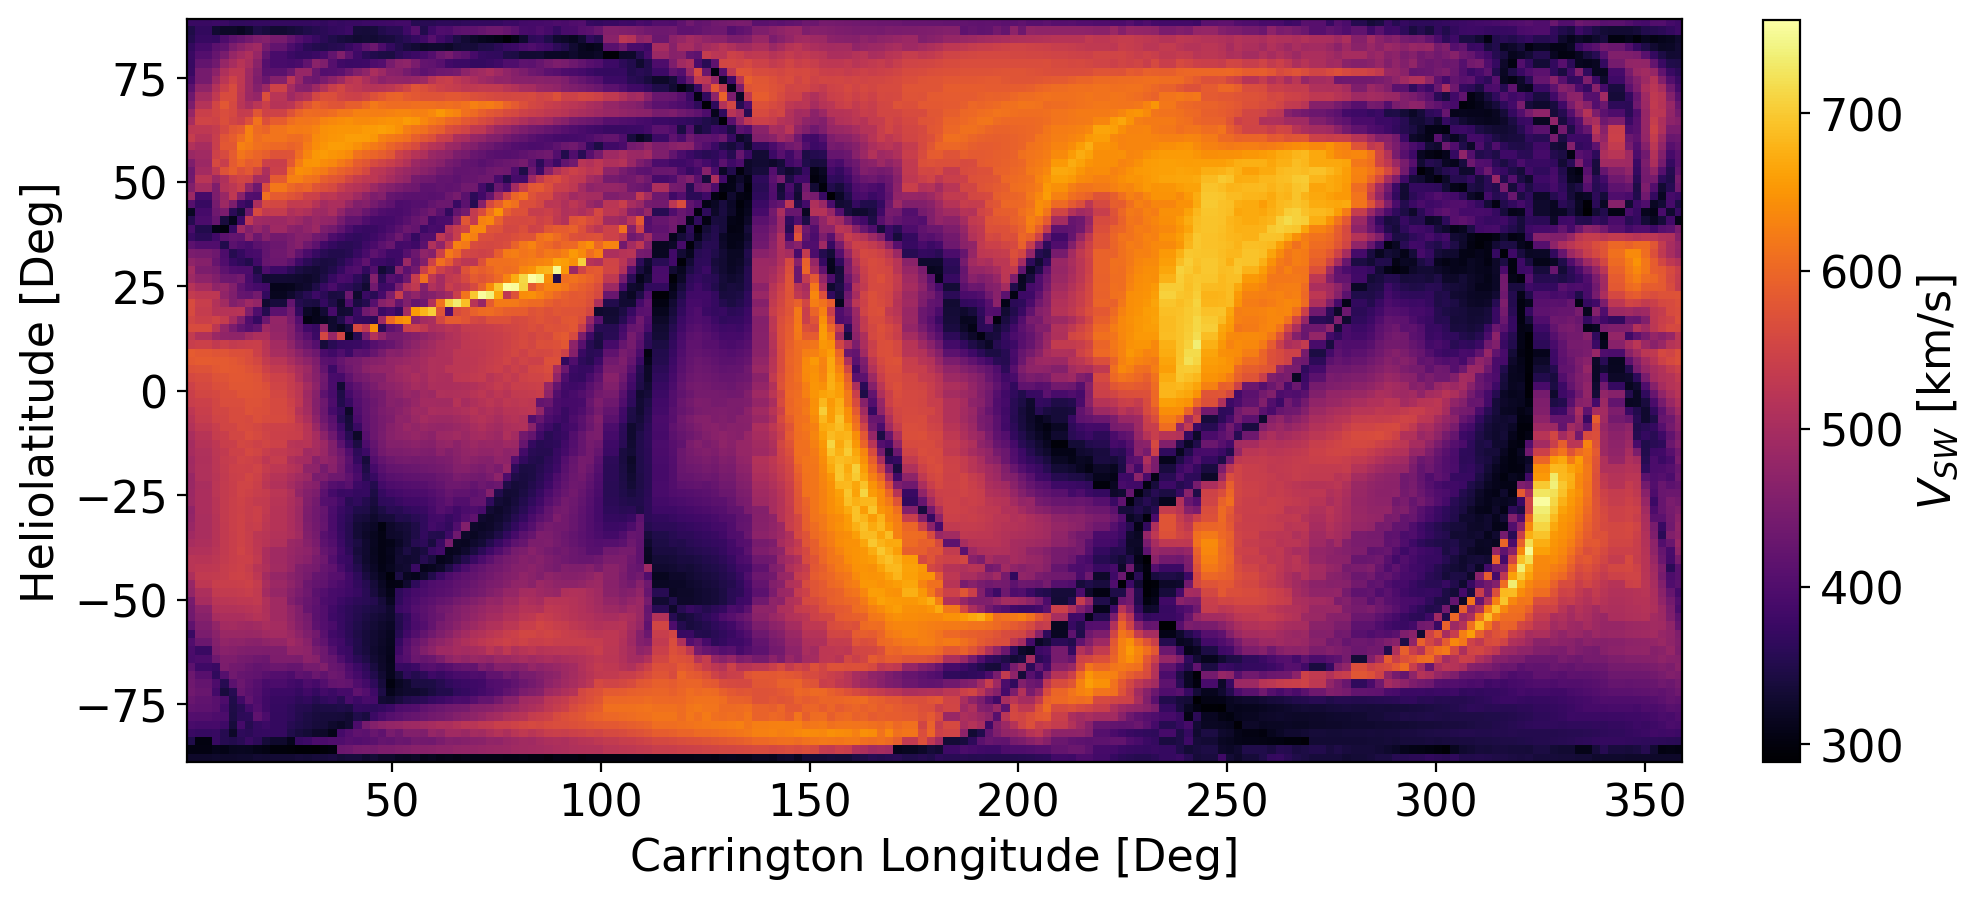

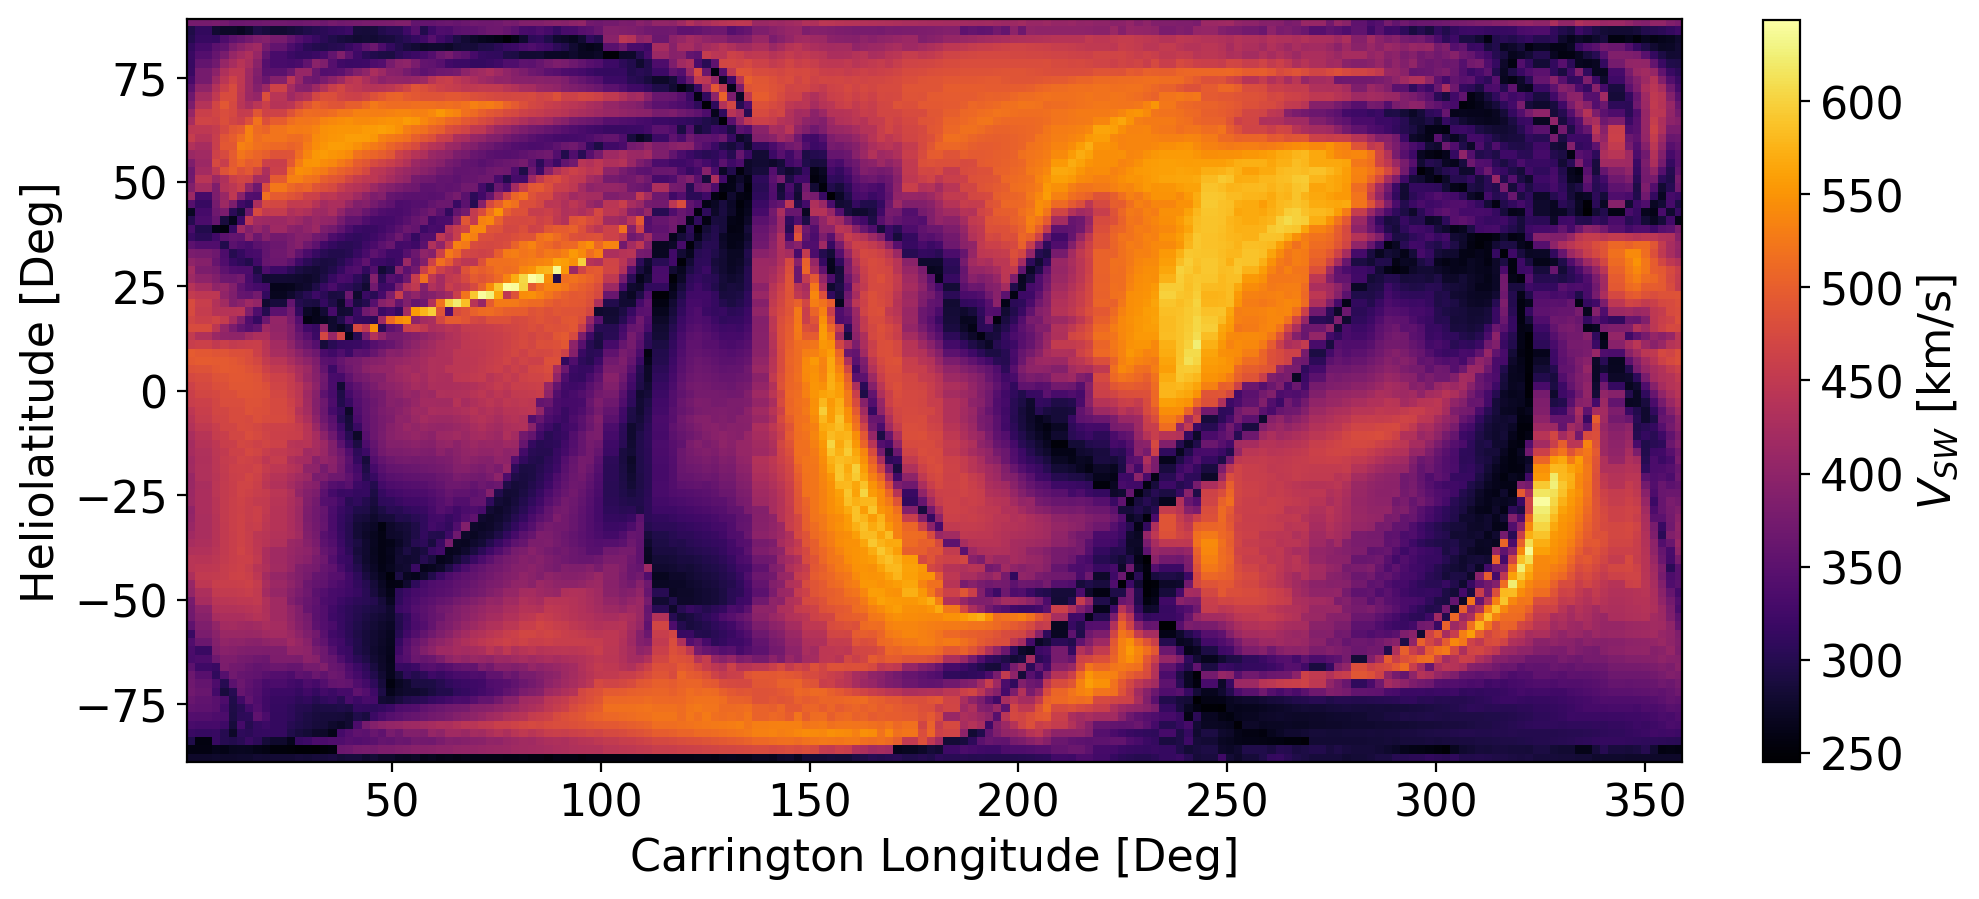

In [69]:
# get all WSA files
directory_path = H._setup_dirs_()['boundary_conditions']
wsa_file_words = ['wsa'] # keywords to filter for in coronal model file directory

# create wsa filepaths
wsa_fnames = get_files_containing_words(directory_path, wsa_file_words)
wsafilepaths = [os.path.join(directory_path, fname) for fname in wsa_fnames]


WSA_vr_map, WSA_vr_longs, WSA_vr_lats, WSA_br_map, WSA_br_lats, WSA_br_longs, WSA_cr = Hin.get_WSA_maps(wsafilepaths[0])


# deaccelerate the WSA map from 1-AU calibrated speeds to expected 21.5 rS values
vr_map_deacc = WSA_vr_map.copy()

for nlat in range(1, len(WSA_vr_lats)):
    vr_map_deacc[nlat, :], lon_temp = Hin.map_v_inwards(WSA_vr_map[nlat, :], 215 * u.solRad, WSA_vr_longs, 21.5 * u.solRad)
 

plt.figure(dpi=200, figsize = (10,6))

plt.imshow(WSA_vr_map.value, cmap = 'inferno', 
           extent = [WSA_vr_longs[0].to(u.deg).value, WSA_vr_longs[-1].to(u.deg).value,
                     WSA_vr_lats[0].to(u.deg).value,WSA_vr_lats[-1].to(u.deg).value])

plt.colorbar(label = r'$V_{SW}$ [km/s]', fraction = 0.023)

plt.xlabel('Carrington Longitude [Deg]')
plt.ylabel('Heliolatitude [Deg]')

plt.tight_layout()
plt.show()

plt.figure(dpi=200, figsize = (10,6))

plt.imshow(vr_map_deacc.value, cmap = 'inferno', 
           extent = [WSA_vr_longs[0].to(u.deg).value, WSA_vr_longs[-1].to(u.deg).value,
                     WSA_vr_lats[0].to(u.deg).value,WSA_vr_lats[-1].to(u.deg).value])

plt.colorbar(label = r'$V_{SW}$ [km/s]', fraction = 0.023)

plt.xlabel('Carrington Longitude [Deg]')
plt.ylabel('Heliolatitude [Deg]')

plt.tight_layout()
plt.show()

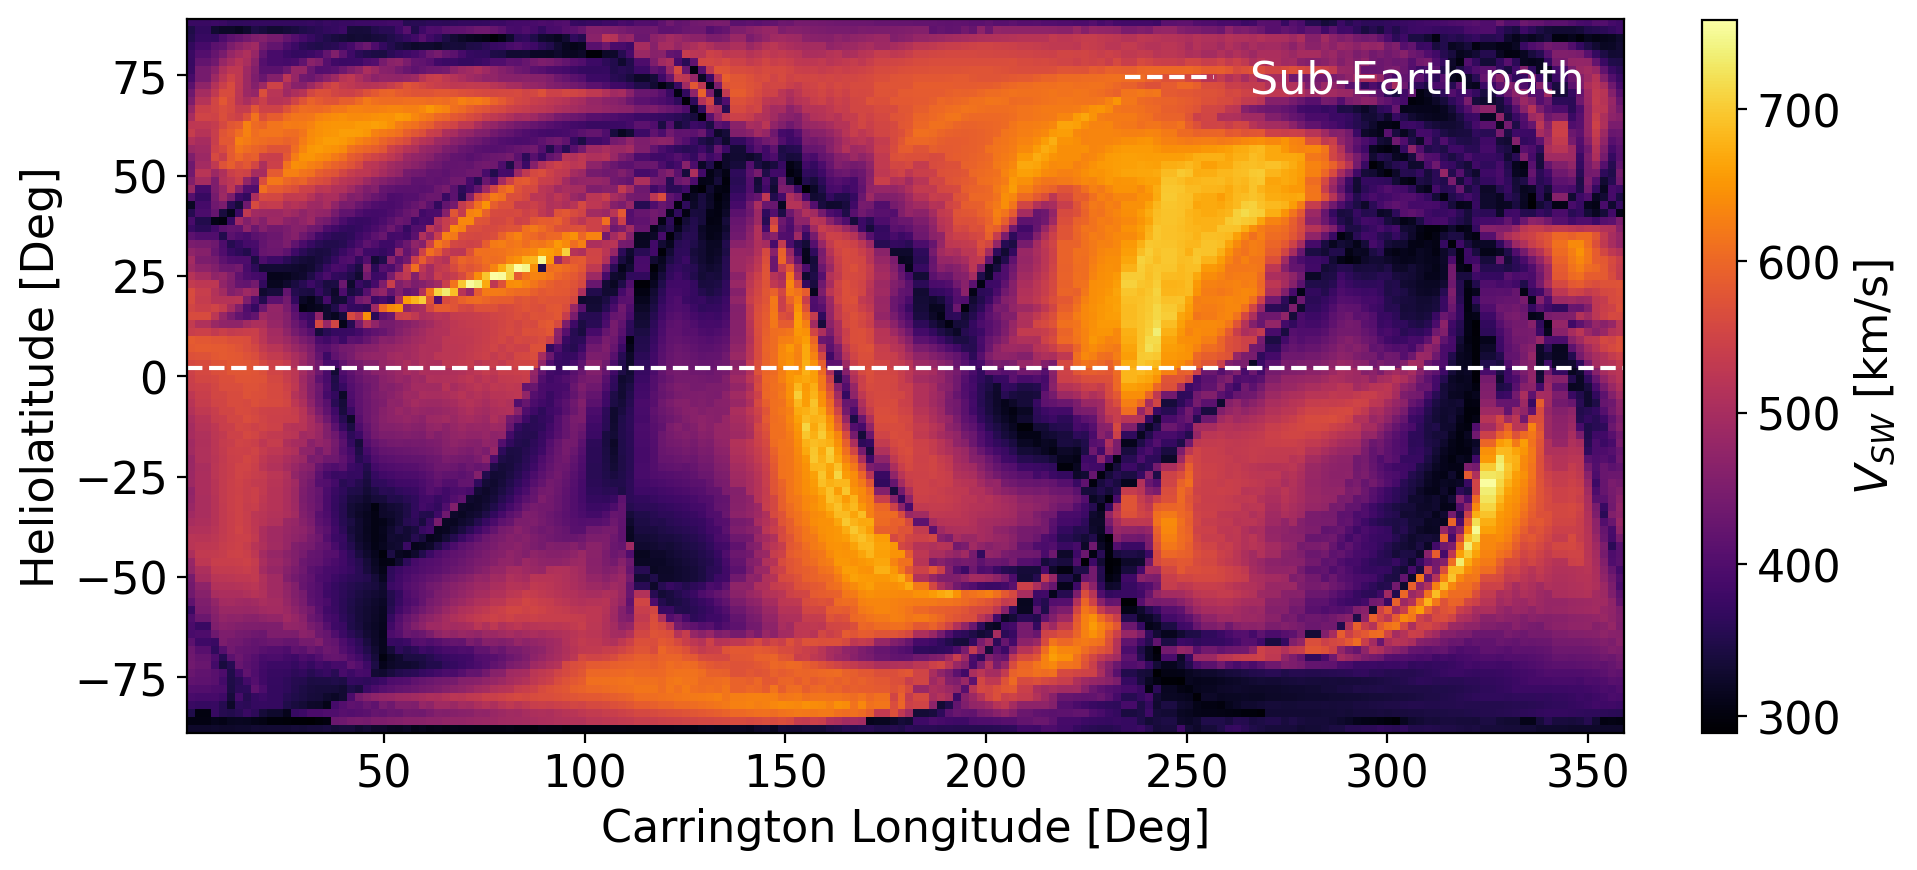

In [71]:
INT = interpolate_vmap(WSA_vr_map.value, WSA_vr_lats.value, WSA_vr_longs.value)
E_lat = earth_latitude_wsa(filename = wsa_fnames[0])
E_boundary = extract_interpolated_velocity_boundary(interpolated_map_solution=INT, boundary=E_lat.value*np.ones(180), longitudes=WSA_vr_longs.value)

INT_deacc = interpolate_vmap(vr_map_deacc.value, WSA_vr_lats.value, WSA_vr_longs.value)
E_lat_deacc = earth_latitude_wsa(filename = wsa_fnames[0])
E_boundary_deacc = extract_interpolated_velocity_boundary(interpolated_map_solution=INT_deacc, boundary=E_lat_deacc.value*np.ones(180), longitudes=WSA_vr_longs.value)

plt.figure(dpi=200, figsize = (10,6))
plt.imshow(WSA_vr_map.value, cmap = 'inferno', 
           extent = [WSA_vr_longs[0].to(u.deg).value, WSA_vr_longs[-1].to(u.deg).value,
                     WSA_vr_lats[0].to(u.deg).value,WSA_vr_lats[-1].to(u.deg).value])

plt.axhline(E_lat.to(u.deg).value, color = 'white', linestyle = '--', label = 'Sub-Earth path')
plt.xlabel('Carrington Longitude [Deg]')
plt.ylabel('Heliolatitude [Deg]')
plt.legend(frameon = False, labelcolor = 'linecolor')
plt.colorbar(label = r'$V_{SW}$ [km/s]', fraction = 0.023)
plt.show()

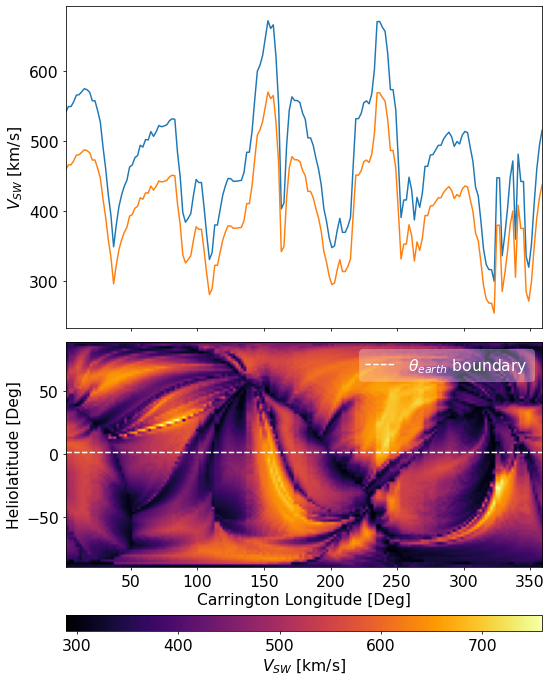

In [72]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (8,10),dpi=70)

axes[0].plot(WSA_vr_longs.to(u.deg).value, E_boundary)
axes[0].plot(WSA_vr_longs.to(u.deg).value, E_boundary_deacc)
axes[0].set_ylabel(r'$V_{SW}$ [km/s]')

im0 = axes[1].imshow(WSA_vr_map.value, cmap = 'inferno', 
           extent = [WSA_vr_longs[0].to(u.deg).value, WSA_vr_longs[-1].to(u.deg).value,
                     WSA_vr_lats[0].to(u.deg).value,WSA_vr_lats[-1].to(u.deg).value], aspect = 'auto')

axes[1].axhline(E_lat.to(u.deg).value, color = 'white', linestyle = '--', label = r'$\theta_{earth}$ boundary')

fig.colorbar(im0, ax = axes[1], label = r'$V_{SW}$ [km/s]', orientation = 'horizontal', aspect = 30)#, location = 'bottom')
axes[1].set_xlabel('Carrington Longitude [Deg]')
axes[1].set_ylabel('Heliolatitude [Deg]')

axes[1].legend(framealpha = 0.3, labelcolor = 'white')

plt.tight_layout()

plt.show()


In [75]:
file_idx = 0

# forecast characteristics
E_lat = earth_latitude_wsa(filename =  wsa_fnames[file_idx]) # sub earth path as basis for 'true' initial conditions
init_wsa_date = wsa_date_from_string(wsa_fnames[file_idx]) # forecast start time
cr, cr_lon_init = Hin.datetime2huxtinputs(pd.Timestamp(init_wsa_date)) # start time translated into carrington rotation + longitudinal component

# generate sub_earth boundary
INT = interpolate_vmap(WSA_vr_map.value, WSA_vr_lats.value, WSA_vr_longs.value)
E_lat = earth_latitude_wsa(filename = wsa_fnames[file_idx])
E_boundary = extract_interpolated_velocity_boundary(interpolated_map_solution=INT, boundary=E_lat.value*np.ones(180), longitudes=WSA_vr_longs.value)

forecast_window = 7 * u.day
r_min = 21.5 * u.solRad

# Generate ensemble of interpolated near-sun velocity boundaries
v_boundary = E_boundary

# set up and run HUXt model. 
model = H.HUXt(v_boundary=v_boundary*(u.km/u.s), cr_num=cr, cr_lon_init=cr_lon_init, simtime=forecast_window, dt_scale=4, r_min = r_min)
model.solve([])

df_earth_series = HA.get_observer_timeseries(model, observer = 'Earth')
df_earth_series = df_earth_series.rename(columns = {'time':'datetime'}) # rename time column to match OMNI dataframe format (for ease later on)
df_earth_series['datetime'] = df_earth_series['datetime'].values.astype(dtype='datetime64[ns]') # setting index to datetime ready for longitudinal perturbation
df_earth_series = df_earth_series.set_index('datetime')


# set up and run HUXt model with deaccelerated . 
model_deacc = H.HUXt(v_boundary=E_boundary_deacc*(u.km/u.s), cr_num=cr, cr_lon_init=cr_lon_init, simtime=forecast_window, dt_scale=4, r_min = r_min)
model_deacc.solve([])

df_earth_series_dc = HA.get_observer_timeseries(model_deacc, observer = 'Earth')
df_earth_series_dc = df_earth_series_dc.rename(columns = {'time':'datetime'}) # rename time column to match OMNI dataframe format (for ease later on)
df_earth_series_dc['datetime'] = df_earth_series_dc['datetime'].values.astype(dtype='datetime64[ns]') # setting index to datetime ready for longitudinal perturbation
df_earth_series_dc = df_earth_series_dc.set_index('datetime')


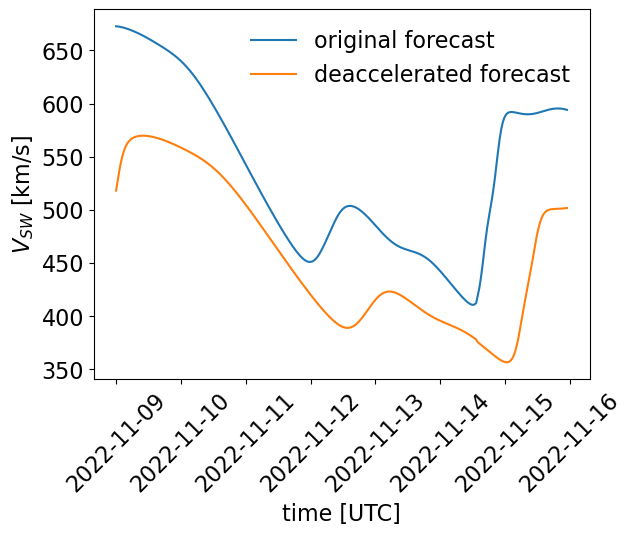

In [76]:
plt.plot(df_earth_series['vsw'], label = 'original forecast')
plt.plot(df_earth_series_dc['vsw'], label ='deaccelerated forecast')
plt.xticks(rotation = 45)
plt.xlabel('time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.legend(frameon=False)
plt.show()

In [77]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

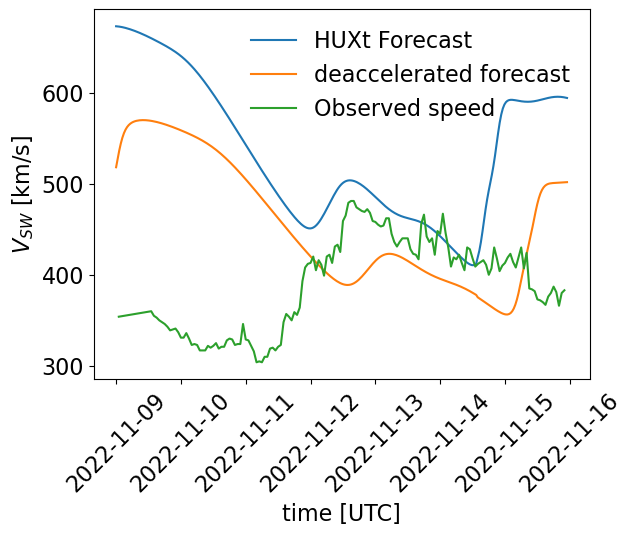

In [78]:
data_chunk = omni_data[df_earth_series.index[0]:df_earth_series.index[-1]]

plt.plot(df_earth_series['vsw'], label = 'HUXt Forecast')
plt.plot(df_earth_series_dc['vsw'], label ='deaccelerated forecast')
plt.plot(data_chunk['V'], label = 'Observed speed')
plt.xticks(rotation = 45)
plt.xlabel('time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.legend(frameon = False)
plt.show()